# This file compares and analyses the IMBI_Marko miner

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:/Users/Marko/Desktop/GIt/IMBI_Master')

In [2]:
from local_pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.log.importer.xes import importer as xes_importer
from local_pm4py.algo.analysis import custom_enum
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py import view_petri_net
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py import precision_alignments
from pm4py import precision_token_based_replay
from pm4py import discover_petri_net_heuristics
from pm4py.convert import convert_to_petri_net
from pm4py.algo.discovery.inductive import algorithm as pm4py_algorithm
from pm4py.algo.discovery.inductive.variants import imf as pm4py_imf
import pandas as pd
from pm4py.algo.discovery.inductive.algorithm import Variants as ind_Variants
import matplotlib.pyplot as plt
import numpy as np
import math
import fpdf
from PIL import Image
import os

In [3]:
def f1_score(a, b):
  # try: catch
  if math.isclose(a+b,0):
    return 0
  return 2 * (a * b) / (a + b)

In [4]:
def visualize_cuts(fileName):
  pdf = fpdf.FPDF(format='letter') #pdf format
  pdf.add_page() #create new page
  pdf.set_font("Arial", size=8) # font and textsize

  i = 0
  try:
    while(True):
      with open("imbi_cuts/cut" + str(i) + ".txt") as f:
        pdf.cell(150, 4, txt="Cut: " + str(i + 1), ln=1, align="C")
        pdf.cell(1000, 4, txt="cut | type | cost_p | cost_m | cost_ratio", ln=1, align="L")
        pdf.cell(1000, 4, txt="", ln=1, align="L")
        lines = f.readlines()
        readLines = 0
        for line in lines:
          if readLines == 0:
            outputLine = line.replace(" ", " | ")
          else:
            outputLine = line
          pdf.cell(1000, 4, txt=outputLine, ln=1, align="L")
          readLines += 1
          if readLines == 3:
            readLines = 0
            pdf.cell(1000, 4, txt="", ln=1, align="L")
        img = Image.open("imbi_cuts/cut" + str(i) + ".png")
        width,height = img.size
        # print(width, height)
        pdf.image("imbi_cuts/cut" + str(i) + ".png",w=min(150,width/3),h=min(150,height/3))
        pdf.add_page()
      i += 1
  except:
    pdf.output(fileName + ".pdf")

In [16]:
def visualize_petriNet(df, miner, logPName, logMName = ""):
  df_temp = df[df["miner"] == miner]
  df_temp = df_temp[df_temp["logM_Name"] == logMName]
  df_temp = df_temp[df_temp["logP_Name"] == logPName]
  for net, im, fm in zip(df_temp.net, df_temp.im, df_temp.fm):
    print("Displaying: " + str(miner) + " " + str(logPName) + " " + str(logMName))
    view_petri_net(net, im, fm)

In [6]:
def visualize_All_petriNet(df, miner):
  df_temp = df[df["miner"] == miner]
  for logPName, logMName in zip(df_temp.logP_Name, df_temp.logM_Name):
    visualize_petriNet(df,miner,logPName,logMName)

In [7]:
def add_Model_To_Database(df,log, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  
  parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT:"pdf"}
  gviz = pn_visualizer.apply(net, im, fm, parameters=parameters)

  try:
    fitness_token = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)["log_fitness"]
  except:
    fitness_token = 0
  try:
    fitness_align = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)["log_fitness"]
  except:
    fitness_align = 0
    
  try:
    prec_token = precision_token_based_replay(log, net, im, fm)
  except:
    prec_token = 0
    
  try:
    prec_alignment = precision_alignments(log, net, im, fm)
  except:
    prec_alignment = 0

  df = pd.concat([df, pd.DataFrame.from_records([{
      "miner" : name,
      "logP_Name": logPName,
      "logM_Name": logMName,
      "imf_noise_thr" : imf_noiseThreshold,
      "hm_depen_thr" : hm_dependency_threshold,
      "im_bi_sup" : im_bi_sup,
      "im_bi_ratio" : im_bi_ratio,
      "fit_tok": fitness_token,
      "fit_alig": fitness_align,
      "prec_tok": prec_token,
      "prec_alig": prec_alignment,
      "f1_tok": f1_score(fitness_token, prec_token),
      "f1_alig": f1_score(fitness_align, prec_alignment),
      "net": net,
      "im" : im,
      "fm" : fm
  }])])
  return df

In [8]:
def applyMinerToLog(df, logPathP, logPathM,logPName, logMName = "", noiseThreshold = 0.0, dependency_threshold=0.0, support = 0, ratio = 0):
  logP = xes_importer.apply(logPathP)
  if logMName == "":
    # inductive miner
    print("Running IM")
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IM)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP,net=net,im=im,fm=fm,name="IM",logPName=logPName)
    
    #imf 
    print("Running IMF")
    parameters = {pm4py_imf.IMFParameters.NOISE_THRESHOLD : noiseThreshold}
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IMf, parameters=parameters)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP,net=net,im=im,fm=fm,name="IMF",logPName=logPName,imf_noiseThreshold=noiseThreshold)
    
    #hm
    print("Running HM")
    net, im, fm = discover_petri_net_heuristics(logP,dependency_threshold=dependency_threshold)
    df = add_Model_To_Database(df=df, log=logP,net=net,im=im,fm=fm,name="HM",logPName=logPName,hm_dependency_threshold=dependency_threshold)
    
    logM = logP
  else:
    logM = xes_importer.apply(logPathM)
    
  # imbi_ali
  print("Running IMbi_ali")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_FREQUENCY_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df,log=logP,net=net,im=im,fm=fm,name="IMbi_ali",logPName=logPName, logMName=logMName,im_bi_sup=support,im_bi_ratio=ratio)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  #imbi_mar
  print("Running IMbi_mar")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_RELATION_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df, log=logP,net=net,im=im,fm=fm,name="IMbi_mar",logPName=logPName, logMName=logMName, im_bi_sup=support,im_bi_ratio=ratio)
  
  visualize_cuts("cuts_IMbi_mar_" + logPName[:logPName.rfind(".")])
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  
  return df

In [9]:
columns = ["miner", "logP_Name", "logM_Name","imf_noise_thr","hm_depen_thr","im_bi_sup","im_bi_ratio", "fit_tok", "fit_alig", "prec_tok", "prec_alig", "f1_tok", "f1_alig", "net", "im", "fm"]
df = pd.DataFrame(data=None, index=None, columns=columns, dtype=None, copy=None)

In [10]:
rootPath = "C:/Users/Marko/Desktop/IMbi_Data/analysing/"

lpNames = ["lp_2012.xes", "lp_2017.xes", "lp_2018.xes"]
# lpNames = ["lp_2012.xes"]

lMNames = ["lm_2012.xes", "lm_2017.xes", "lm_2018.xes"]
lpPaths = []
lmPaths = []

for lp in lpNames:
  lpPaths.append((lp,rootPath + lp))
for lm in lMNames:
  lmPaths.append((lm,rootPath + lm))
  

In [11]:
i = 1
for pairLP in lpPaths:
  print("Running: " + pairLP[0] + " " + str(i) + "/" + str(len(lpPaths)))
  df = applyMinerToLog(df,pairLP[1],pairLP[1],pairLP[0],"", 0.2, 0.99, 1, 0)
  i += 1

Running: lp_2012.xes 1/3


c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 7672.72it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 357.13it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1535.68it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 767.91it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1686.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 834.97it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2529.42it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 886.58it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 3308.17it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1061.74it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 3745.07it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1061.72it/s]


Running: lp_2017.xes 2/3


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1587.72it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:11<00:00, 39.70it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 551.01it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:14<00:00, 84.51it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1521.58it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:03<00:00, 343.19it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2360.24it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 647.23it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 3396.44it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 779.84it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1701.92it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 578.30it/s]


Running: lp_2018.xes 3/3


parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2598.52it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 40.68it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 507.46it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:17<00:00, 76.13it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 633.69it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 223.72it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1114.28it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 3688.46it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 840.30it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 4073.74it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 733.81it/s]


'F1 measure: f1_tok'

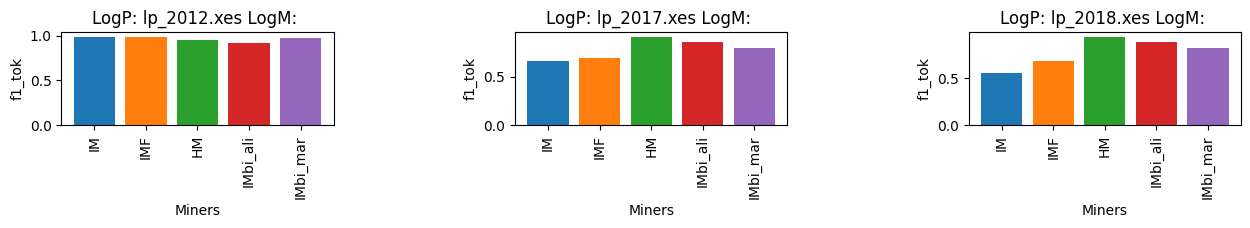

'F1 measure: f1_alig'

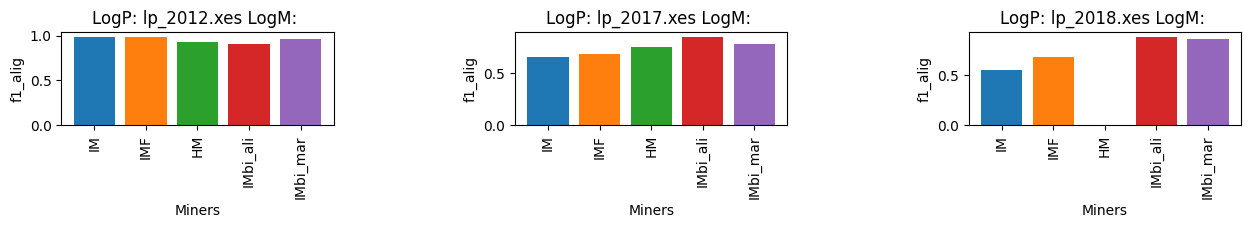

In [13]:

# display f1 score subplots
df_grouped = df.groupby(by=["logP_Name",	"logM_Name"], group_keys=True).apply(lambda x : x)
# display(dfN)

numberOfPlotPerRow = 3
rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)


for f1_measure in ["f1_tok", "f1_alig"]:
  fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
  fig.tight_layout(pad=10.0)
  cur_Row = 0
  cur_Col = 0
  for logGroup in df_grouped.index.unique():
    df_log_grouped = df_grouped.loc[logGroup]
    axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1])
    axs[cur_Row,cur_Col].set_ylabel(f1_measure)
    axs[cur_Row,cur_Col].set_xlabel("Miners")
    j = 0
    xTickLabel = []
    idx = []
    for miner, f1_tok in zip(df_log_grouped.miner, df_log_grouped[f1_measure]):
      axs[cur_Row,cur_Col].bar(j,f1_tok, label=str(miner))
      xTickLabel.append(miner)
      idx.append(j)
      j += 1
    axs[cur_Row,cur_Col].set_xticks(idx)
    axs[cur_Row,cur_Col].set_xticklabels(xTickLabel, rotation=90)
    cur_Col += 1
    if cur_Col == numberOfPlotPerRow:
      cur_Row += 1
      cur_Col = 0
      
    
  display("F1 measure: " + f1_measure)
  plt.show()
  fig.savefig("plot_" + f1_measure + ".pdf")


#alignment

Displaying: IM lp_2018.xes 


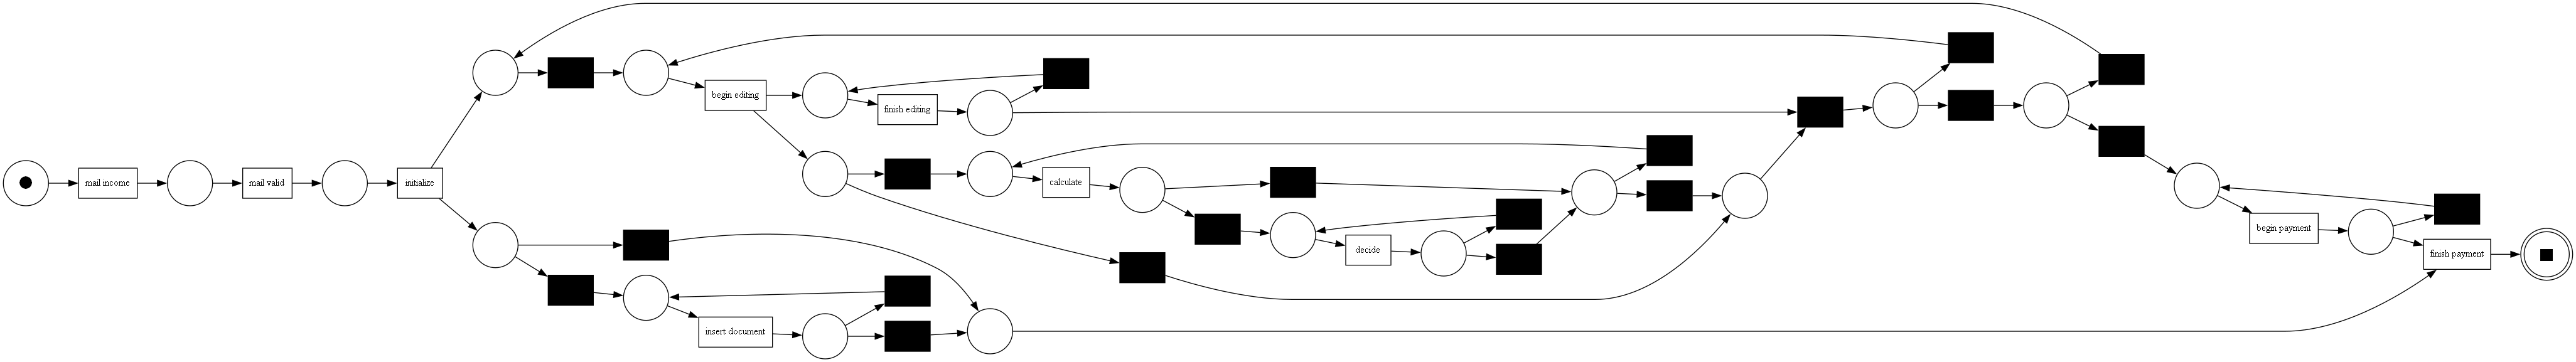

Displaying: IMbi_mar lp_2018.xes 


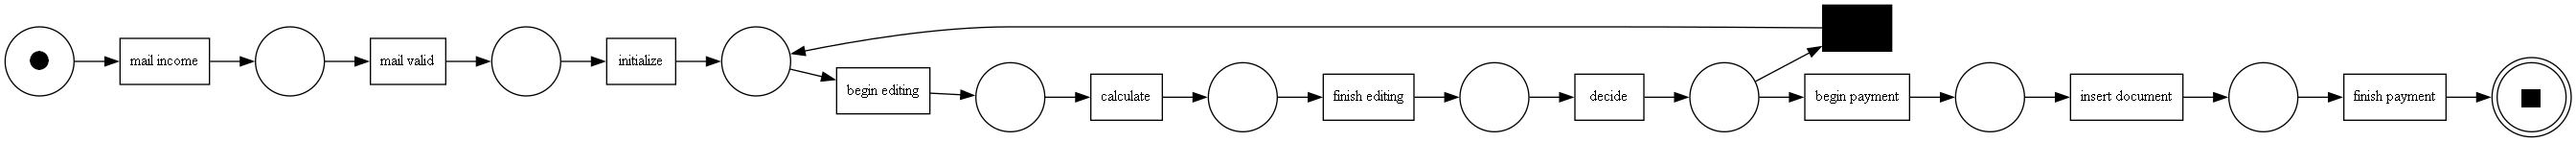

Displaying: IMbi_ali lp_2018.xes 


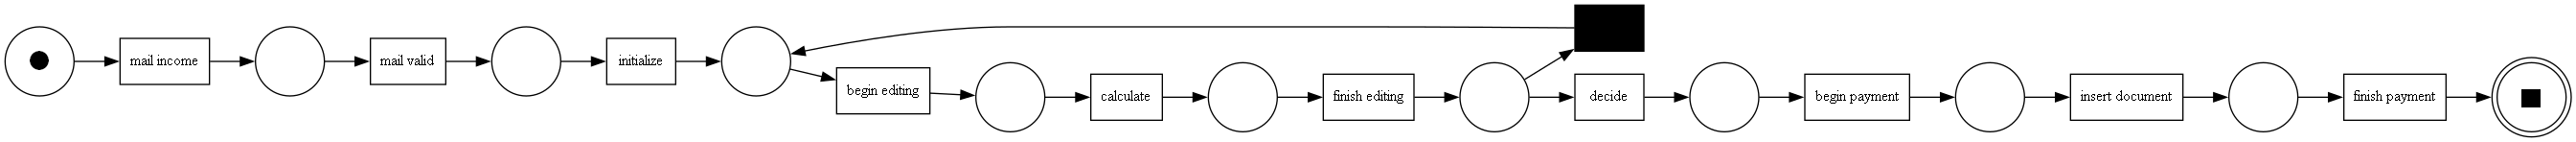

In [19]:
visualize_petriNet(df, "IM", "lp_2018.xes")
visualize_petriNet(df, "IMbi_mar", "lp_2018.xes")
visualize_petriNet(df, "IMbi_ali", "lp_2018.xes")

In [14]:
display(df)

,miner,logP_Name,logM_Name,imf_noise_thr,hm_depen_thr,im_bi_sup,im_bi_ratio,fit_tok,fit_alig,prec_tok,prec_alig,f1_tok,f1_alig,net,im,fm
0,IM,lp_2012.xes,,0,0,0,0,1.000000,0.999975,0.978462,0.978462,0.989114,0.989102,"places: [ p_12, p_13, p_14, p_15, p_3, p_4, p_...",{source: 1},{sink: 1}
0,IMF,lp_2012.xes,,0.2,0,0,0,0.998129,0.998613,0.977643,0.977643,0.987780,0.988017,"places: [ p_12, p_13, p_14, p_15, p_3, p_4, p_...",{source: 1},{sink: 1}
0,HM,lp_2012.xes,,0,0.99,0,0,0.895280,0.867262,1.000000,1.000000,0.944747,0.928913,"places: [ intplace_A_ACCEPTED, intplace_A_PART...",{source0: 1},{sink0: 1}
0,IMbi_ali,lp_2012.xes,,0,0,1,0,0.851909,0.826372,1.000000,1.000000,0.920033,0.904933,"places: [ p_10, p_11, p_12, p_3, p_4, p_5, p_6...",{source: 1},{sink: 1}
0,IMbi_mar,lp_2012.xes,,0,0,1,0,0.936911,0.925798,1.000000,1.000000,0.967428,0.961469,"places: [ p_10, p_11, p_12, p_3, p_4, p_5, p_8...",{source: 1},{sink: 1}
0,IM,lp_2017.xes,,0,0,0,0,1.000000,0.999921,0.492170,0.492170,0.659670,0.659653,"places: [ p_11, p_12, p_13, p_14, p_15, p_16, ...",{source: 1},{sink: 1}
0,IMF,lp_2017.xes,,0.2,0,0,0,0.971095,0.961927,0.540599,0.540599,0.694550,0.692190,"places: [ p_10, p_14, p_15, p_17, p_22, p_23, ...",{source: 1},{sink: 1}
0,HM,lp_2017.xes,,0,0.99,0,0,0.844251,0.605225,0.999467,0.999467,0.915325,0.753917,"places: [ intplace_A_Complete, intplace_A_Inco...",{source0: 1},{sink0: 1}
0,IMbi_ali,lp_2017.xes,,0,0,1,0,0.863741,0.863844,0.851387,0.851387,0.857519,0.857570,"places: [ p_10, p_11, p_12, p_13, p_14, p_15, ...",{source: 1},{sink: 1}
0,IMbi_mar,lp_2017.xes,,0,0,1,0,0.900946,0.890832,0.709528,0.709528,0.793861,0.789910,"places: [ p_10, p_11, p_12, p_13, p_14, p_16, ...",{source: 1},{sink: 1}
